<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC

# # tensorflow for nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [20]:
# Adjust the display settings to increase the width
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap DataFrame horizontally
pd.set_option('display.width', 240)  # Set the maximum width of the display

In [21]:
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/features.csv' -O features.csv
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/targets.csv' -O targets.csv

--2024-04-22 20:40:02--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146525 (143K) [text/plain]
Saving to: ‘features.csv’

features.csv        100%[===================>] 143.09K  --.-KB/s    in 0.02s   

2024-04-22 20:40:02 (6.13 MB/s) - ‘features.csv’ saved [146525/146525]

--2024-04-22 20:40:02--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/targets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [22]:
# Load the downloaded CSV files into pandas DataFrames
features = pd.read_csv('features.csv')
targets = pd.read_csv('targets.csv')

In [23]:
# Results storage for confusion matrices, classification reports, and ROC curves
confusion_matrices = []
roc_curves = []
classification_reports = []
accuracy = []

In [24]:
# Convert categorical variable into dummy/indicator variables (one-hot encoding)
X = pd.get_dummies(features)

# Store feature names after one-hot encoding, as they will be needed for interpreting the model's feature importances
feature_names = X.columns.tolist()

# Assign the encoded diagnosis column to y, which serves as the target variable for the model
y = targets['Diagnosis_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure the same set of columns in both train and test sets
# - 'join=left' ensures all columns in X_train are kept, aligning X_test to it
# - 'axis=1' specifies that the alignment is to be done on columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [25]:
# Create an imputer object that replaces NaN values with the median of the column
imputer = SimpleImputer(strategy='median')

# Standardize the data
scaler = StandardScaler()

In [26]:
# Create a RandomForestClassifier with a specified number of estimators and a fixed random state for reproducibility
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline that first imputes missing values then trains a model
pipeline = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('classifier', rf_model)])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = pipeline.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy.append(accuracy_rf)

# Calculate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
confusion_matrices.append(cm_rf)

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_rf, tpr_rf))

# Calculate classification report
cls_report_rf = classification_report(y_test, y_pred_rf)
classification_reports.append(cls_report_rf)

# Print the accuracy and a classification report to see performance details
print("Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", cm_rf)
print("Classification Report:\n", cls_report_rf)

Accuracy: 0.9162995594713657
Confusion Matrix:
 [[116   4]
 [ 15  92]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.92       120
           1       0.96      0.86      0.91       107

    accuracy                           0.92       227
   macro avg       0.92      0.91      0.92       227
weighted avg       0.92      0.92      0.92       227



In [27]:
# Create a pipeline that first imputes missing values then trains a model
pipeline = Pipeline(steps=[('imputer', imputer), ('scaler', scaler), ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = pipeline.predict(X_test)

# Calculate confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
confusion_matrices.append(cm_lr)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy.append(accuracy_lr)

# Calculate ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_lr, tpr_lr))

# Calculate classification report
cls_report_lr = classification_report(y_test, y_pred_lr)
classification_reports.append(cls_report_lr)

# Evaluate the model
print("Accuracy:", accuracy_lr)
print("Confusion Matrix:\n", cm_lr)
print("Classification Report:\n", cls_report_lr)

Accuracy: 0.9074889867841409
Confusion Matrix:
 [[112   8]
 [ 13  94]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       120
           1       0.92      0.88      0.90       107

    accuracy                           0.91       227
   macro avg       0.91      0.91      0.91       227
weighted avg       0.91      0.91      0.91       227



In [28]:
# Set up the Gradient Boosting Classifier with current learning rate
gbs_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42)

# Create and fit the pipeline
gbs_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', gbs_model)
])
gbs_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_gbs = gbs_pipeline.predict(X_test)

# Calculate accuracy
accuracy_gbs = accuracy_score(y_test, y_pred_gbs)
accuracy.append(accuracy_gbs)

# Calculate confusion matrix
conf_matrix_gbs = confusion_matrix(y_test, y_pred_gbs)
confusion_matrices.append(conf_matrix_gbs)

# Calculate ROC curve
fpr_gbs, tpr_gbs, _ = roc_curve(y_test, gbs_pipeline.predict_proba(X_test)[:, 1])
roc_curves.append((fpr_gbs, tpr_gbs))

# Calculate classification report
cls_report_gbs = classification_report(y_test, y_pred_gbs)
classification_reports.append(cls_report_gbs)

# Optionally print results for each model
print(f"Learning Rate: {0.05}")
print(f"Accuracy: {accuracy_gbs}")
print(f"Confusion Matrix:\n{conf_matrix_gbs}")
print(f"Classification Report:\n{cls_report_gbs}\n")

Learning Rate: 0.05
Accuracy: 0.9383259911894273
Confusion Matrix:
[[119   1]
 [ 13  94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       120
           1       0.99      0.88      0.93       107

    accuracy                           0.94       227
   macro avg       0.95      0.94      0.94       227
weighted avg       0.94      0.94      0.94       227




In [29]:
# Define a range of learning rates with 0.1 steps between 0 and 1
learning_rates = np.arange(0.1, 1, 0.05)

# Define the parameter grid using the generated learning rates
param_grid = {'classifier__learning_rate': learning_rates}

# Set up the Gradient Boosting Classifier with fixed number of estimators
gbd_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create the pipeline
gbd_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', gbd_model)
])

# Initialize GridSearchCV
grid_search = GridSearchCV(gbd_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to find the best learning rate
grid_search.fit(X_train, y_train)

# Get the best learning rate and its corresponding accuracy
best_learning_rate = grid_search.best_params_['classifier__learning_rate']
best_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_

# Print the best learning rate and its corresponding accuracy
print("Best Learning Rate:", best_learning_rate)
print("Best Accuracy:", best_accuracy)

# Predict on the test set using the best model
y_pred_gbd = best_model.predict(X_test)

# Calculate confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_gbd)

# Calculate classification report for the best model
cls_report_best = classification_report(y_test, y_pred_gbd)

# Calculate ROC curve for the best model
fpr_best, tpr_best, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])

# Store the results in the lists
accuracy.append(best_accuracy)
confusion_matrices.append(conf_matrix_best)
classification_reports.append(cls_report_best)
roc_curves.append((fpr_best, tpr_best))

# Print the results for the best model
print("Accuracy:", best_accuracy)
print("Confusion Matrix:\n", conf_matrix_best)
print("Classification Report:\n", cls_report_best)

Best Learning Rate: 0.40000000000000013
Best Accuracy: 0.9354177897574123
Accuracy: 0.9354177897574123
Confusion Matrix:
 [[119   1]
 [ 13  94]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       120
           1       0.99      0.88      0.93       107

    accuracy                           0.94       227
   macro avg       0.95      0.94      0.94       227
weighted avg       0.94      0.94      0.94       227



In [30]:
# SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Create a pipeline that includes scaling, imputation, and the SVM classifier
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # SVMs require feature scaling for optimal performance
    ('classifier', svm_model)
])

# Fit the SVM model
svm_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred_svm = svm_pipeline.predict(X_test)

cm_svm = confusion_matrix(y_test, y_pred_svm)
confusion_matrices.append(cm_svm)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pipeline.decision_function(X_test))
roc_curves.append((fpr_svm, tpr_svm))

# Calculate accuracy and append it to the list
accuracy.append(accuracy_score(y_test, y_pred_svm))

# Calculate classification report and append it to the list
cls_report_svm = classification_report(y_test, y_pred_svm)
classification_reports.append(cls_report_svm)

# Print the accuracy and a classification report to see performance details
print("Accuracy (SVM):", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

Accuracy (SVM): 0.8634361233480177
Confusion Matrix (SVM):
 [[111   9]
 [ 22  85]]
Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       120
           1       0.90      0.79      0.85       107

    accuracy                           0.86       227
   macro avg       0.87      0.86      0.86       227
weighted avg       0.87      0.86      0.86       227



In [18]:
# Create a pipeline for preprocessing
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Apply transformations and prepare data
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

# Build a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_prepared.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to record training metrics
class MetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy.append(logs['accuracy'])

# Fit the neural network
history = model.fit(X_train_prepared, y_train, epochs=50, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_prepared, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Retrieve the confusion matrix and ROC curve from the neural network's predictions
y_pred_nn = (model.predict(X_test_prepared) > 0.5).astype("int32")
cm_nn = confusion_matrix(y_test, y_pred_nn)
confusion_matrices.append(cm_nn)

fpr_nn, tpr_nn, _ = roc_curve(y_test, model.predict(X_test_prepared))
roc_curves.append((fpr_nn, tpr_nn))

Epoch 1/50
15/15 [==============================] - 1s 19ms/step - loss: 0.5426 - accuracy: 0.7089 - val_loss: 0.5112 - val_accuracy: 0.7736
Epoch 2/50
15/15 [==============================] - 0s 5ms/step - loss: 0.3488 - accuracy: 0.8713 - val_loss: 0.4564 - val_accuracy: 0.7925
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.2563 - accuracy: 0.9072 - val_loss: 0.4175 - val_accuracy: 0.8302
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.2012 - accuracy: 0.9325 - val_loss: 0.3922 - val_accuracy: 0.8302
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.1604 - accuracy: 0.9473 - val_loss: 0.3657 - val_accuracy: 0.8679
Epoch 6/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1300 - accuracy: 0.9641 - val_loss: 0.3660 - val_accuracy: 0.8679
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1044 - accuracy: 0.9747 - val_loss: 0.3483 - val_accuracy: 0.8679
Epoch 8/50
15/15 [=

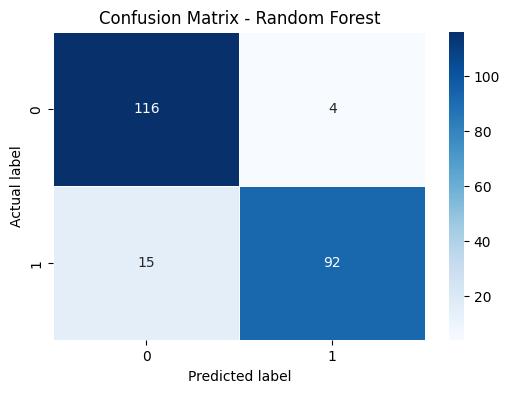

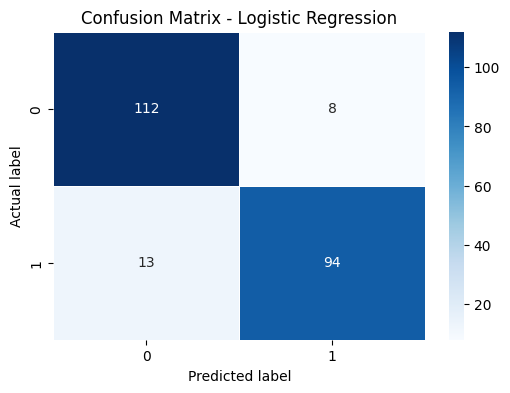

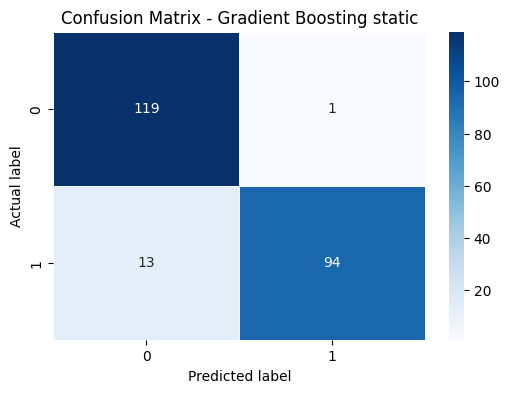

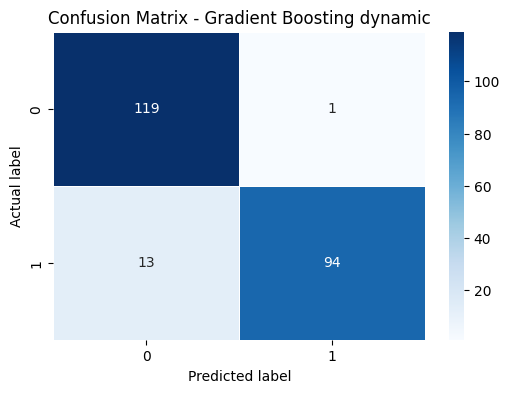

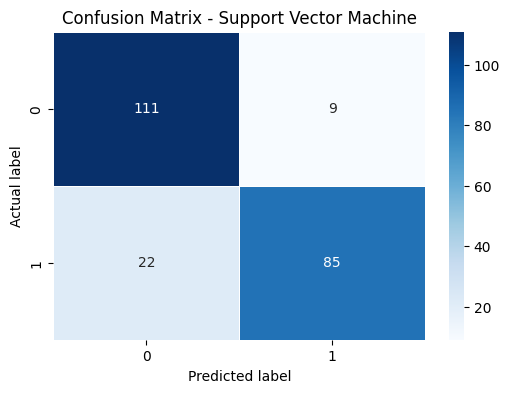

In [31]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Plot confusion matrices
model_names = ["Random Forest", "Logistic Regression", "Gradient Boosting static", "Gradient Boosting dynamic", "Support Vector Machine", "Neural Network"]
for idx, (cm, model_name) in enumerate(zip(confusion_matrices, model_names)):
    plot_confusion_matrix(cm, f'Confusion Matrix - {model_name}')

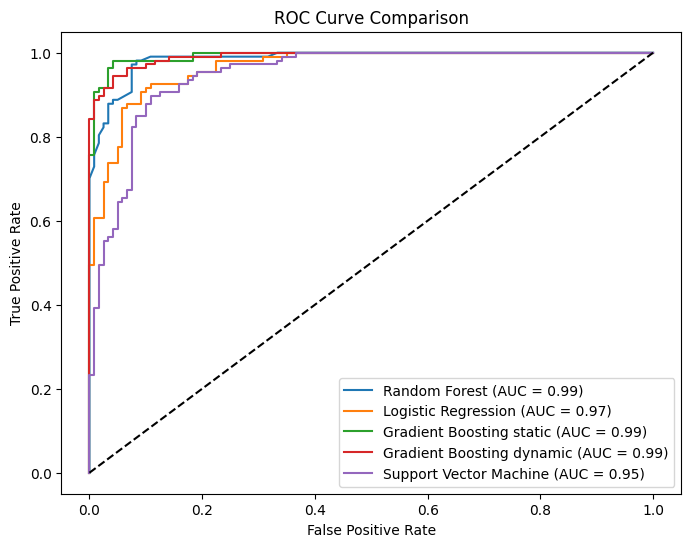

In [32]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for idx, (curve, model_name) in enumerate(zip(roc_curves, model_names)):
    fpr, tpr = curve
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

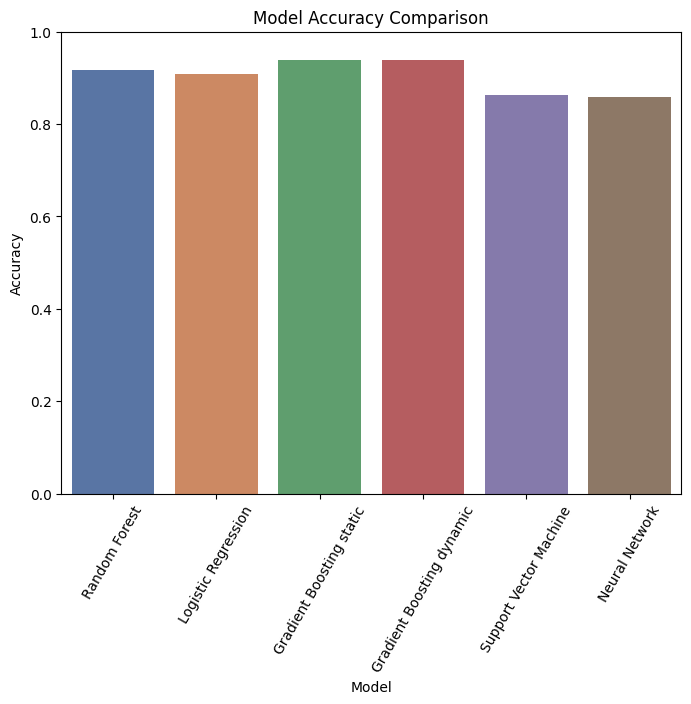

In [33]:
# Collect accuracies for each model
accuracies = [accuracy_score(y_test, y_pred_rf),
              accuracy_score(y_test, y_pred_lr),
              accuracy_score(y_test, y_pred_gbs),
              accuracy_score(y_test, y_pred_gbd),
              accuracy_score(y_test, y_pred_svm),
              accuracy_score(y_test, y_pred_nn)]

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracies, hue=model_names, palette='deep', legend=False)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Set y-axis limits to show percentages from 0 to 100%
plt.xticks(rotation=60)  # Rotate x-axis labels
plt.legend([], frameon=False)  # Hides the legend
plt.show()